# Implementing CPPI nad Drawdown Constraints

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd 
import numpy as np
import edhec_risk_ins as eri

#load the industry returns and the total market index we previously created 
ins_return = eri.get_ins_returns()
tmi_return = eri.get_total_mkt_index_return()

In [5]:
risky_r = ins_return["2000":][["Steel","Fin","Beer"]]

In [6]:
risky_r.shape

(240, 3)

In [7]:
# Safe Asset
safe_r = pd.DataFrame().reindex_like(risky_r) #creat a new dataframe that have the
# same shape with the existed one, we can simply use reindex_like + the one you already have

In [8]:
safe_r.shape #the exact the same shape with risk_r

(240, 3)

In [9]:
safe_r[:] = 0.03/12
start = 1000 #initial investment a lso the start value
floor = 0.8 #set the floor which is 80% of start value

1. Cushion - (Asset Value minus Floor Value)
2. Compute an Allocation to safe and Risky Assets -> m*risk budget
3. Recompute the Asset Value based on the returns

In [10]:
def compound1(r):
    return (1+r).prod()-1

def compound2(r):
    return np.expm1(np.log1p(r).sum()) 
# originally it should be-- np.exp(np.log(1+r).sum - 1) which is a loop nut is not efficient
# expm1 which is exp of the () and minus 1

In [11]:
compound1(risky_r)

Steel    0.052394
Fin      2.711831
Beer     4.507649
dtype: float64

In [12]:
compound2(risky_r)

Steel    0.052394
Fin      2.711831
Beer     4.507649
dtype: float64

In [13]:
%timeit compound1(risky_r)

1.72 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
%timeit compound2(risky_r)

573 µs ± 123 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Back to CPPI

In [15]:
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start * floor
m = 3
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion = (account_value - floor_value)/account_value #risk_budget
    # how much money to allocate to risky asset and safe asset
    risky_w = m*cushion
    risky_w = np.minimum(risky_w,1)
    risky_w = np.maximum(risky_w,0) #weight of risky asset is no more than 100% and no lower than 
    safe_w = 1 - risky_w
    risky_alloc = account_value * risky_w
    safe_alloc = account_value * safe_w
    ## update the account value for this time step
    account_value = risky_alloc*(1+risky_r.iloc[step])+safe_alloc*(1+safe_r.iloc[step])
    # save the values so I can look at the history and plot ets
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value

In [16]:
account_history.head()

,Steel,Fin,Beer
2000-01,984.380000,974.480000,987.320000
2000-02,1023.292876,931.167544,922.971256
2000-03,1047.555176,998.187296,924.835988
2000-04,1042.079009,973.927479,939.993701
2000-05,1007.137753,1001.460033,991.145489


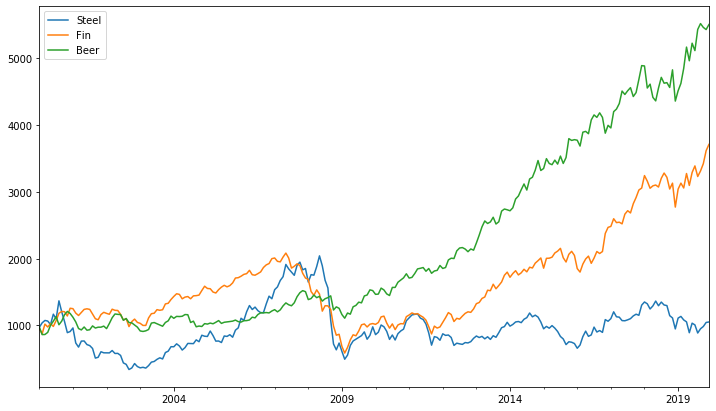

In [17]:
risky_wealth = start*(1+risky_r).cumprod()
risky_wealth.plot(figsize=(12,7))

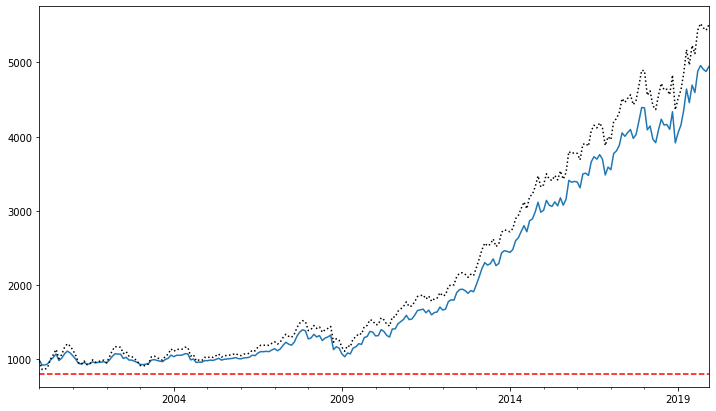

In [18]:
ax = account_history["Beer"].plot(figsize=(12,7)) 
risky_wealth["Beer"].plot(ax=ax, style="k:") # k means black
ax.axhline(y=floor_value, color='r', linestyle="--") # horizontal line

+ the blue line is the CCPI dynamic mix of risky asset of beer and safe asset
+ while the dotted line is single investing in the beer risky asset
+ as we can see the floor needs to be updated

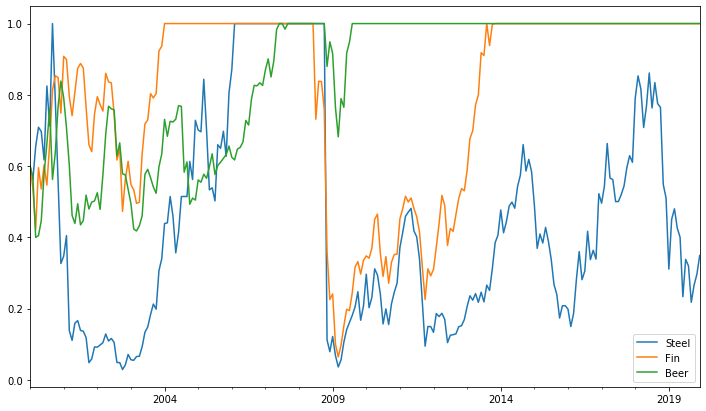

In [19]:
risky_w_history.plot(figsize=(12,7))

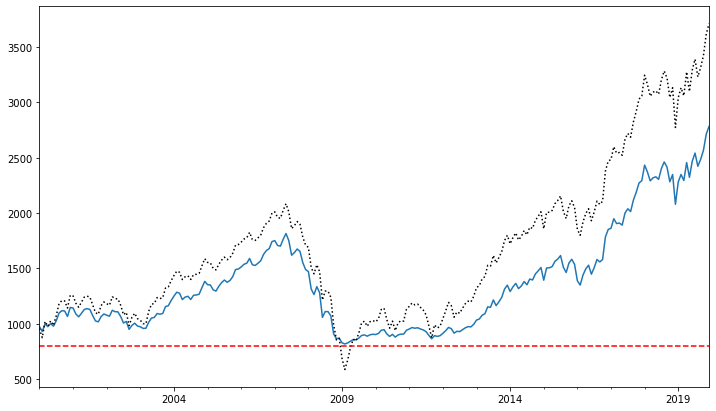

In [20]:
ind = "Fin"
ax = account_history[ind].plot(figsize=(12,7)) 
risky_wealth[ind].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color='r', linestyle="--")

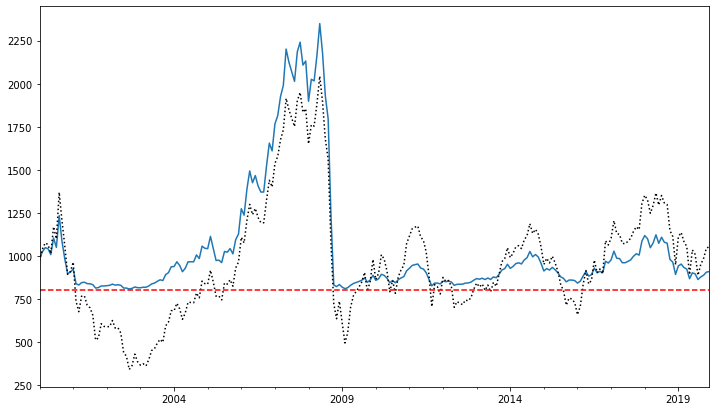

In [21]:
ind = "Steel"
ax = account_history[ind].plot(figsize=(12,7)) 
risky_wealth[ind].plot(ax=ax, style="k:")
ax.axhline(y=floor_value, color='r', linestyle="--")

In [22]:
eri.Summary_Stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var(5%),HistoricCVaR(5%),Sharp Ratio,Max Drawrown
Steel,0.002557,0.313083,-0.306167,4.049934,0.149728,0.208900,0.208900,-0.758017
Fin,0.067774,0.191697,-0.544378,4.957943,0.089854,0.132183,0.132183,-0.718465
Beer,0.089051,0.138107,-0.497734,4.145452,0.062033,0.091442,0.091442,-0.271368


In [23]:
btr = eri.run_cppi(risky_r)
eri.Summary_Stats(btr["wealth"].pct_change().dropna()) #convert wealth to returns

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var(5%),HistoricCVaR(5%),Sharp Ratio,Max Drawrown
Steel,-0.003993,0.171372,-1.994615,17.362607,0.090198,0.130157,0.130157,-0.655198
Fin,0.054105,0.133864,-0.854270,5.724951,0.064985,0.091638,0.091638,-0.549673
Beer,0.084248,0.115822,-0.639804,4.632368,0.052268,0.074908,0.074908,-0.259582


In [72]:
import numpy as np
tmi_return = eri.get_total_mkt_index_return()
tmi_return["2000":].head()

2000-01    2.347859e+06
2000-02    2.393538e+06
2000-03    2.570756e+06
2000-04    2.454333e+06
2000-05    2.378673e+06
Freq: M, Name: wealth, dtype: float64

In [21]:
#btr = eri.run_cppi(tmi_return["2000":])
#ax = btr["wealth"].plot(figsize=(12,7),legend=False)
#btr["Risky wealth"].plot(ax=ax,style="k--",legend=False)

In [57]:
eri.Summary_Stats(btr["wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var(5%),HistoricCVaR(5%),Sharp Ratio,Max Drawrown
Steel,-0.003993,0.171372,-1.994615,17.362607,0.090198,0.130157,0.130157,-0.655198
Fin,0.054105,0.133864,-0.854270,5.724951,0.064985,0.091638,0.091638,-0.549673
Beer,0.084248,0.115822,-0.639804,4.632368,0.052268,0.074908,0.074908,-0.259582


In [50]:
eri.Summary_Stats(btr["Risky wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var(5%),HistoricCVaR(5%),Sharp Ratio,Max Drawrown
Steel,0.003982,0.313657,-0.310044,4.039102,0.149990,0.208900,0.208900,-0.758017
Fin,0.070494,0.191753,-0.554495,4.978464,0.089792,0.132183,0.132183,-0.718465
Beer,0.090702,0.138224,-0.506326,4.153862,0.062047,0.091442,0.091442,-0.271368


## Drawdown Constraint 

In [66]:
import edhec_risk_ins as eri
btr = eri.run_cppi(ins_return["2007":][["Steel","Fin","Beer"]], drawdown = 0.25)

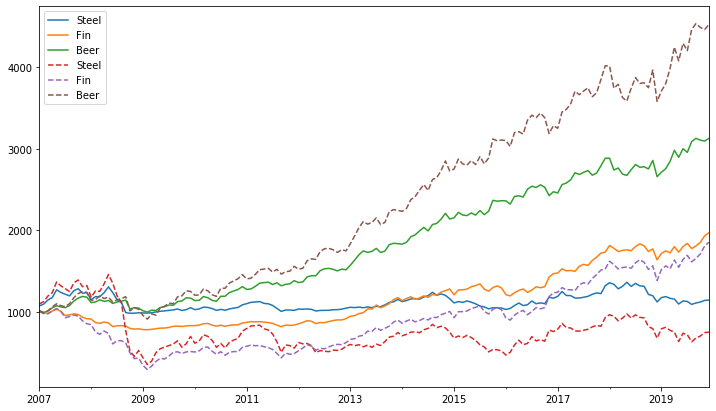

In [68]:
ax = btr["wealth"].plot(figsize = (12,7))
btr["Risky wealth"].plot(ax=ax,style="--")

In [69]:
eri.Summary_Stats(btr["Risky wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var(5%),HistoricCVaR(5%),Sharp Ratio,Max Drawrown
Steel,-0.028847,0.308100,-0.412415,4.572899,0.151462,0.206662,0.206662,-0.758017
Fin,0.048599,0.209176,-0.717350,4.651397,0.102858,0.149875,0.149875,-0.718465
Beer,0.122589,0.127292,-0.653245,4.544283,0.055253,0.077388,0.077388,-0.271368


In [70]:
eri.Summary_Stats(btr["wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher Var(5%),HistoricCVaR(5%),Sharp Ratio,Max Drawrown
Steel,0.005044,0.096624,-0.435159,5.071322,0.047100,0.068037,0.068037,-0.248059
Fin,0.053622,0.086817,-0.359033,3.834070,0.038484,0.054114,0.054114,-0.243626
Beer,0.091263,0.086073,-0.709718,4.446857,0.037164,0.051189,0.051189,-0.161186
